# Import needed modules

In [28]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [30]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/CLDP/coleaf-dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [31]:
df

,filepaths,labels
0,/content/drive/MyDrive/CLDP/coleaf-dataset/pho...,phosphorus-P
1,/content/drive/MyDrive/CLDP/coleaf-dataset/pho...,phosphorus-P
2,/content/drive/MyDrive/CLDP/coleaf-dataset/pho...,phosphorus-P
3,/content/drive/MyDrive/CLDP/coleaf-dataset/pho...,phosphorus-P
4,/content/drive/MyDrive/CLDP/coleaf-dataset/pho...,phosphorus-P
...,...,...
671,/content/drive/MyDrive/CLDP/coleaf-dataset/bor...,boron-B
672,/content/drive/MyDrive/CLDP/coleaf-dataset/bor...,boron-B
673,/content/drive/MyDrive/CLDP/coleaf-dataset/bor...,boron-B
674,/content/drive/MyDrive/CLDP/coleaf-dataset/bor...,boron-B


### **Split dataframe into train, valid, and test**

In [32]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [33]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 540 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.
Found 55 validated image filenames belonging to 4 classes.


In [34]:
# Create ImageDataGenerator with augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Flip gambar secara horizontal
    vertical_flip=True,  # Flip gambar secara vertikal
    fill_mode='nearest'  # Cara mengisi pixel yang kosong setelah transformasi
)

# Buat generator untuk data train dengan augmentasi
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validasi dan test generator tetap menggunakan pengaturan sebelumnya tanpa augmentasi
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 540 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.
Found 55 validated image filenames belonging to 4 classes.


### **Show sample from train data**

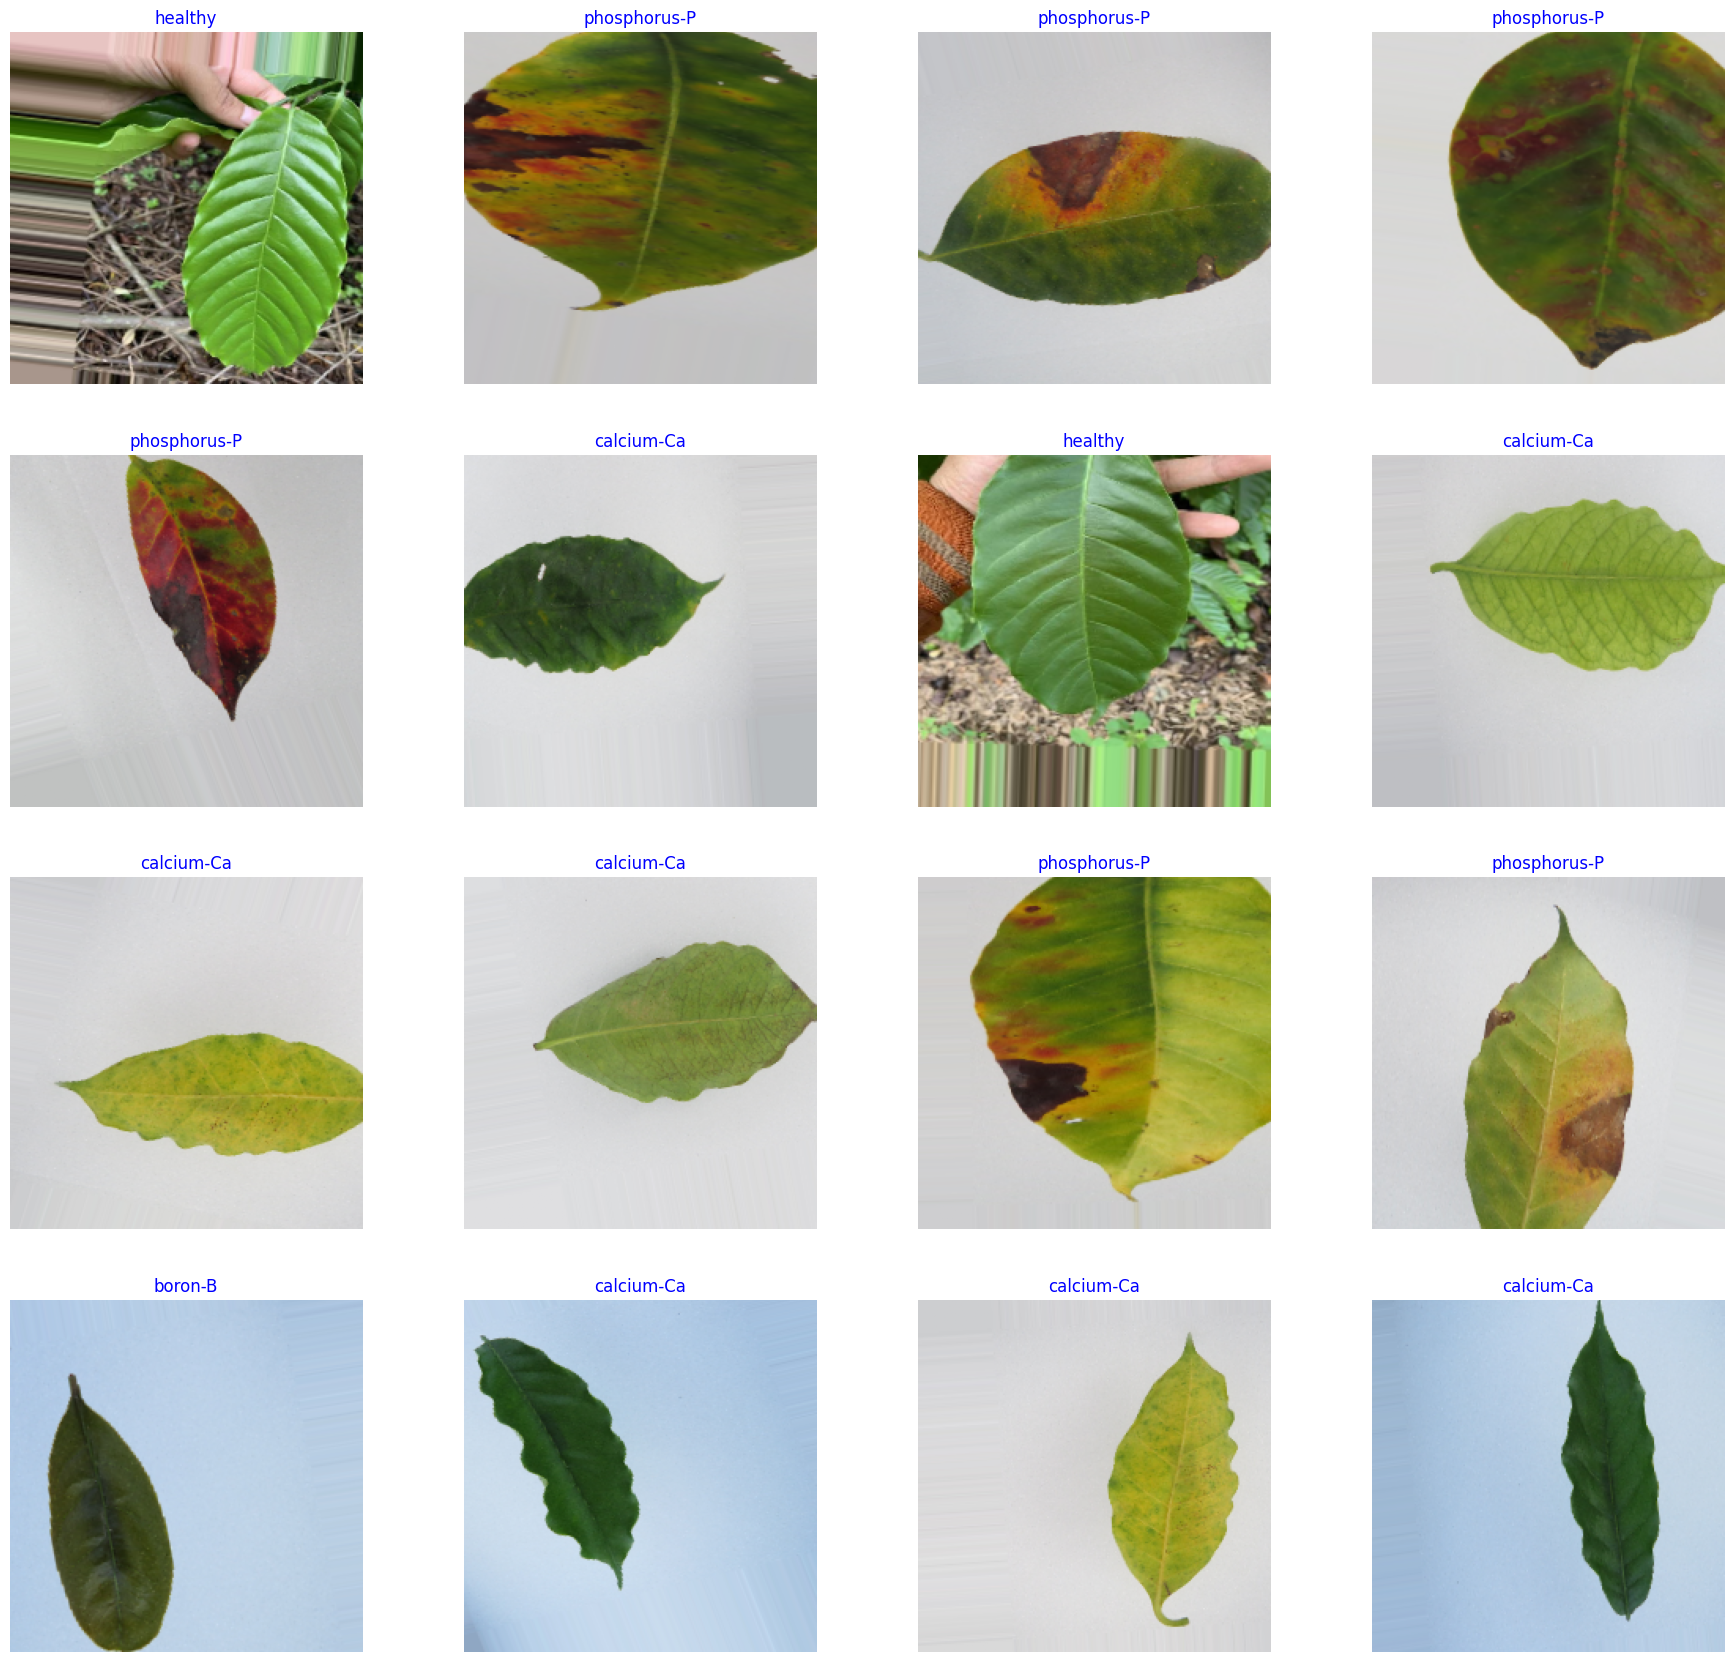

In [35]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [36]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.5, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_7 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 4383655 (16.72 MB)
Trainable params: 433

#### **Train model**

In [37]:
# Jumlah epoch dan batch size
epochs = 20
batch_size = 16

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    steps_per_epoch=len(train_gen),  # Jumlah langkah per epoch diatur ke panjang generator train
    validation_steps=len(valid_gen),  # Langkah validasi set ke panjang generator validasi
    shuffle=False  # Shuffling sudah dilakukan di dalam generator
)

Epoch 1/20
34/34 [==============================] - 65s 1s/step - loss: 8.2968 - accuracy: 0.7222 - val_loss: 8.2188 - val_accuracy: 0.7901
Epoch 2/20
34/34 [==============================] - 40s 1s/step - loss: 7.3269 - accuracy: 0.8556 - val_loss: 7.1627 - val_accuracy: 0.8519
Epoch 3/20
34/34 [==============================] - 38s 1s/step - loss: 6.7058 - accuracy: 0.9037 - val_loss: 6.4221 - val_accuracy: 0.9259
Epoch 4/20
34/34 [==============================] - 37s 1s/step - loss: 6.2240 - accuracy: 0.9056 - val_loss: 5.9512 - val_accuracy: 0.9259
Epoch 5/20
34/34 [==============================] - 39s 1s/step - loss: 5.7509 - accuracy: 0.9296 - val_loss: 5.5635 - val_accuracy: 0.9259
Epoch 6/20
34/34 [==============================] - 39s 1s/step - loss: 5.3763 - accuracy: 0.9315 - val_loss: 5.2647 - val_accuracy: 0.9259
Epoch 7/20
34/34 [==============================] - 38s 1s/step - loss: 5.0465 - accuracy: 0.9296 - val_loss: 4.8841 - val_accuracy: 0.9506
Epoch 8/20
34/34 [==

#### **Display model performance**

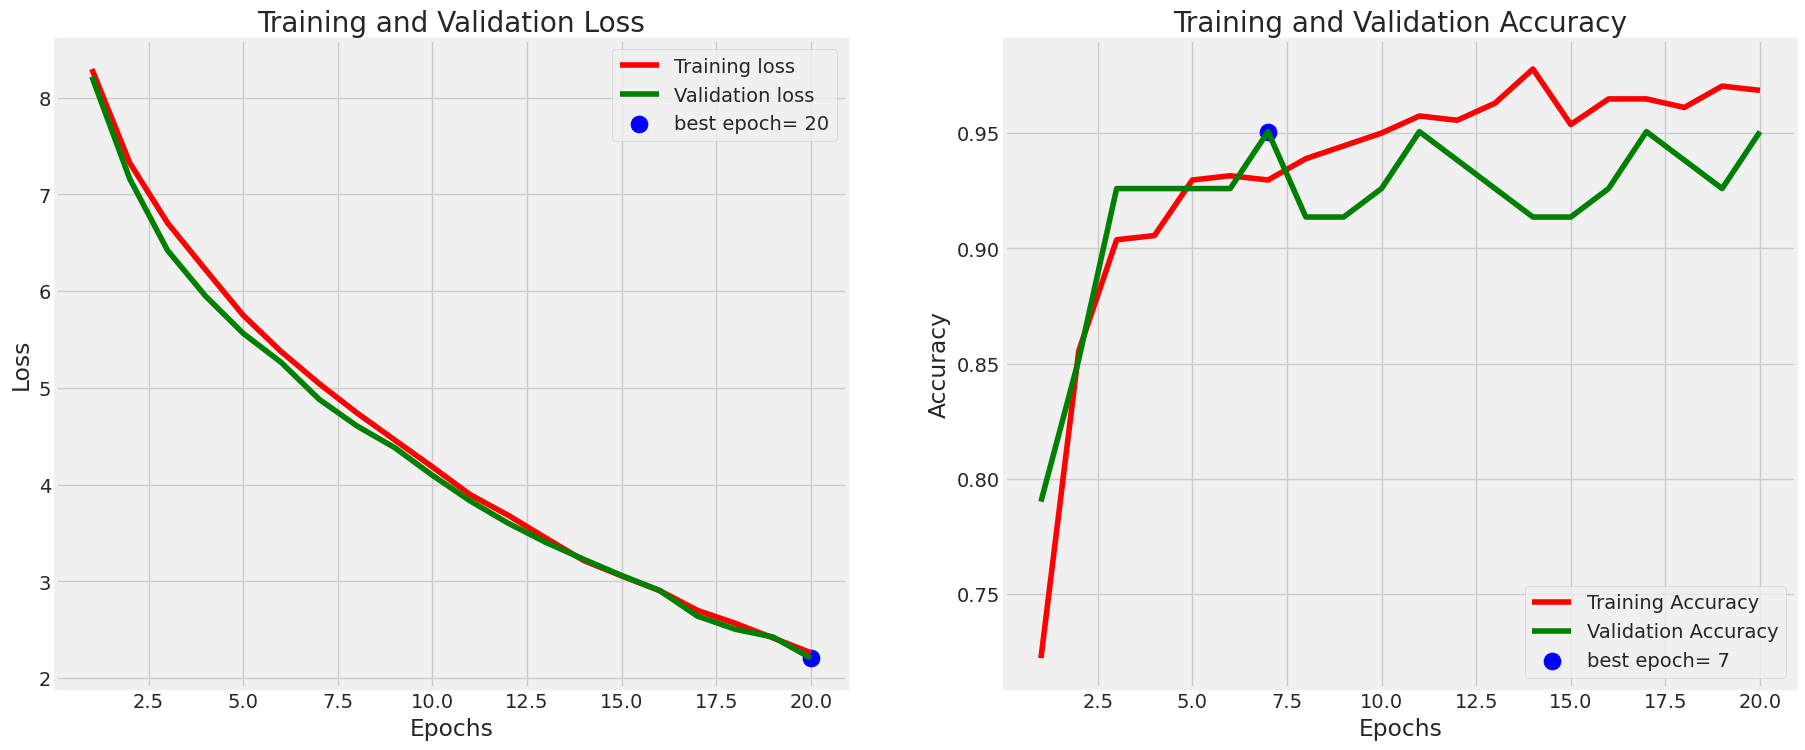

In [38]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [39]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 4s 4s/step - loss: 2.3120 - accuracy: 0.9273
Train Loss:  2.1357228755950928
Train Accuracy:  1.0
--------------------
Validation Loss:  2.3888347148895264
Validation Accuracy:  0.8125
--------------------
Test Loss:  2.3119802474975586
Test Accuracy:  0.9272727370262146


# **Get Predictions**

In [40]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

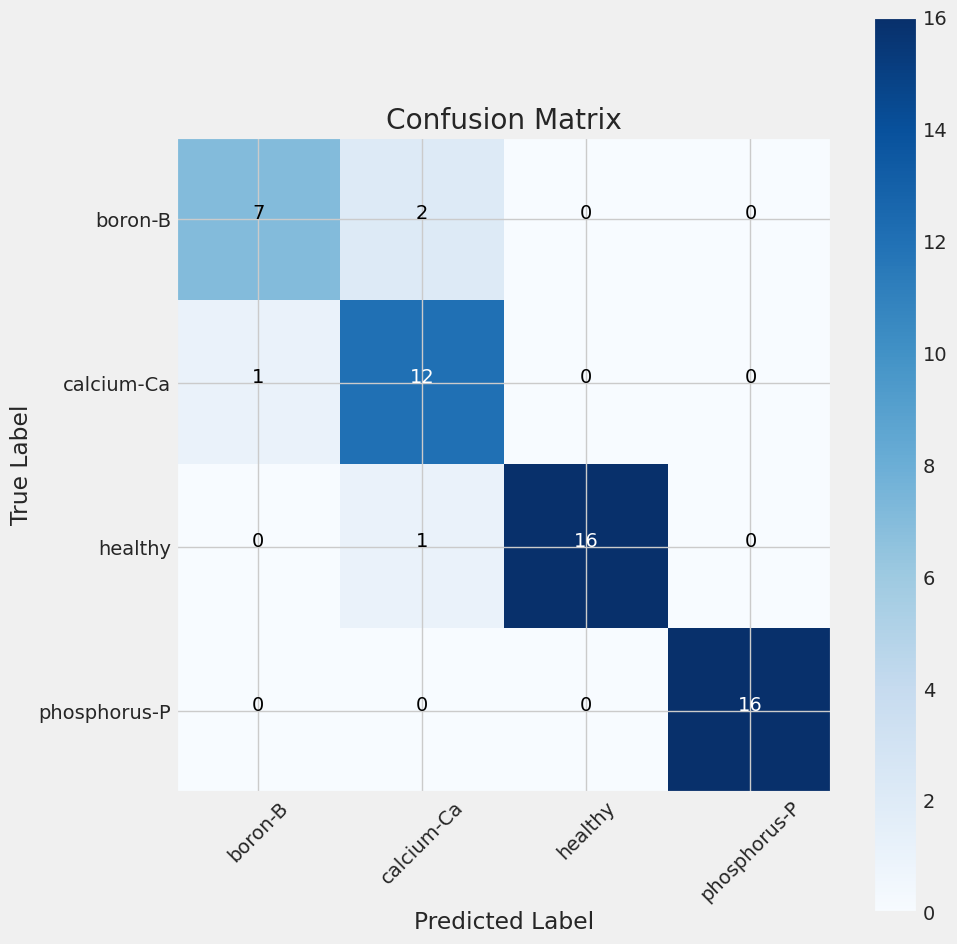

In [41]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [42]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

     boron-B       0.88      0.78      0.82         9
  calcium-Ca       0.80      0.92      0.86        13
     healthy       1.00      0.94      0.97        17
phosphorus-P       1.00      1.00      1.00        16

    accuracy                           0.93        55
   macro avg       0.92      0.91      0.91        55
weighted avg       0.93      0.93      0.93        55



#### **Save model**

In [43]:
model_name = model.input_names[0][:-6]
subject = 'Coffee Leaf Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Coffee Leaf Diseases-92.73.h5
weights were saved as efficientnetb0-Coffee Leaf Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [44]:
# class_dict = train_gen.class_indices
# img_size = train_gen.image_shape
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join(save_path, csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [45]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [54]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
#from tensorflow import keras
import random
from PIL import Image, ImageOps
import numpy as np

import warnings
warnings.filterwarnings("ignore")


st.set_page_config(
    page_title="Coffe Leaf Disease Detection",
    page_icon = ":coffee:",
    initial_sidebar_state = 'auto'
)
hide_streamlit_style = """
            <style>
            #MainMenu {visibility: hidden;}
            footer {visibility: hidden;}
            </style>
            """
st.markdown(hide_streamlit_style, unsafe_allow_html=True)

def prediction_cls(prediction):
    for key, clss in class_names.items():
        if np.argmax(prediction)==clss:

            return key


with st.sidebar:
        st.image('coleaf.jpg')
        st.title("Kelompok 7 - Sains Data ITERA")
        st.subheader("Accurate detection of diseases present in the Coffee leaves. This helps an user to easily detect the disease and identify it's cause.")


@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('efficientnetb0-Coffee Leaf Diseases-92.73.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()
    #model = keras.Sequential()
    #model.add(keras.layers.Input(shape=(224, 224, 4)))


st.write("""
         # Coffee Leaf Disease Detection with Remedy Suggestion
         """
         )

file = st.file_uploader("", type=["jpg", "png"])
def import_and_predict(image_data, model):
        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.Resampling.LANCZOS)
        img = np.asarray(image)
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    x = random.randint(98,99)+ random.randint(0,99)*0.01
    st.sidebar.error("Accuracy : " + str(x) + " %")

    class_names = ['healthy', 'boron-B', 'calcium-Ca', 'phosphorus-P']

    string = "Detected Disease : " + class_names[np.argmax(predictions)]
    if class_names[np.argmax(predictions)] == 'healthy':
        st.balloons()
        st.sidebar.success(string)

    elif class_names[np.argmax(predictions)] == 'boron-B':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Pastikan tanaman kopi mendapat pupuk boron sesuai petunjuk. Siram tanaman dengan benar, hindari genangan air. Lakukan analisis tanah untuk pemahaman yang lebih baik. Pantau tanaman dan daun untuk deteksi dini gejala kekurangan boron.")


    elif class_names[np.argmax(predictions)] == 'calcium-Ca':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan kalsium pada tanaman kopi, perlu dilakukan pemupukan dengan pupuk kalsium sesuai petunjuk penggunaannya. Pastikan pH tanah berada dalam kisaran optimal agar kalsium dapat diserap dengan baik. Melakukan analisis tanah sangat penting untuk mengetahui tingkat kekurangan kalsium secara spesifik guna perencanaan pemupukan yang tepat. Selain itu, pantau secara rutin tanaman untuk mengidentifikasi tanda-tanda kekurangan kalsium dan lakukan perawatan yang diperlukan. Menggunakan bahan organik seperti kompos juga bisa membantu meningkatkan ketersediaan kalsium dalam tanah.")

    elif class_names[np.argmax(predictions)] == 'phosphorus-P':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan fosfor pada tanaman kopi, tambahkan pupuk fosfor ke tanah sesuai petunjuk penggunaannya. Pastikan pH tanah optimal agar tanaman dapat menyerap fosfor dengan baik. Lakukan analisis tanah secara teratur untuk memantau dan menyesuaikan pemupukan sesuai kebutuhan tanaman. Pemupukan fosfor yang tepat penting untuk pertumbuhan akar, pembungaan, dan kualitas hasil panen kopi.")


Overwriting app.py


In [47]:
!pip install pyngrok

In [48]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-12-20 12:38:36--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  14.0MB/s    in 1.0s    

2023-12-20 12:38:38 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [49]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [50]:
get_ipython().system_raw('./ngrok http 8501 &')

In [51]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range
